In [178]:
# 1
# a
import numpy as np
import gzip
import struct
def read_idx(filename):
    with gzip.open(filename, "rb") as f:
        zero, data_type, dims = struct.unpack(">HBB", f.read(4))
        shape = tuple(struct.unpack(">I", f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
test_images = read_idx("MNIST/t10k-images-idx3-ubyte.gz")
test_labels = read_idx("MNIST/t10k-labels-idx1-ubyte.gz")
train_images = read_idx("MNIST/train-images-idx3-ubyte.gz")
train_labels = read_idx("MNIST/train-labels-idx1-ubyte.gz")
print("Test images shape: ", test_images.shape)
print("Test labels shape: ", test_labels.shape)
print("Train images shape: ", train_images.shape)
print("Train labels shape: ", train_labels.shape)

Test images shape:  (10000, 28, 28)
Test labels shape:  (10000,)
Train images shape:  (60000, 28, 28)
Train labels shape:  (60000,)


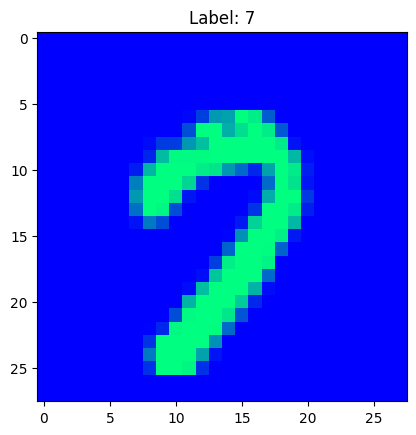

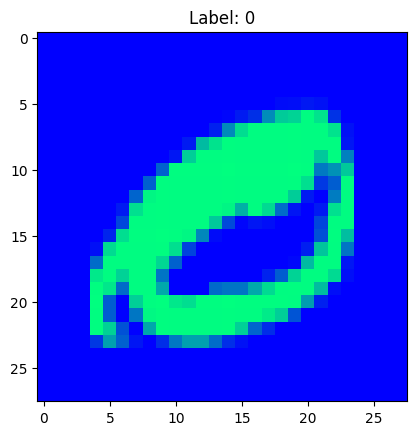

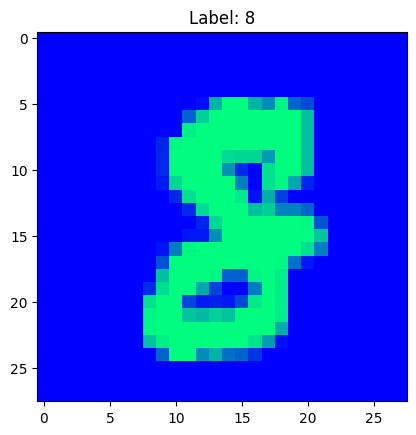

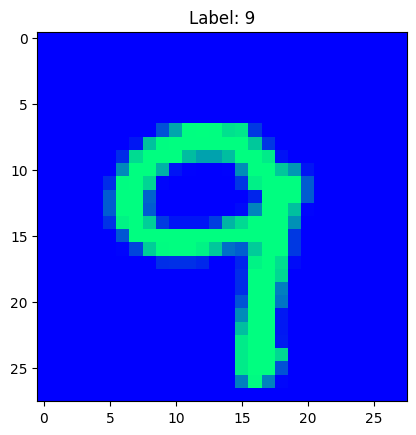

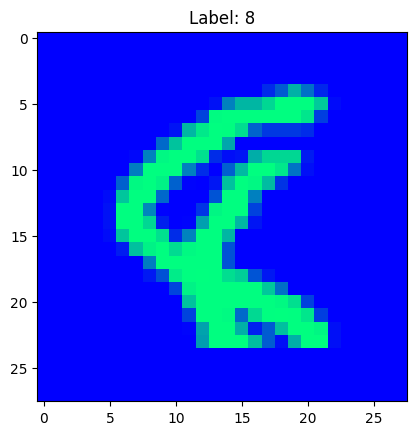

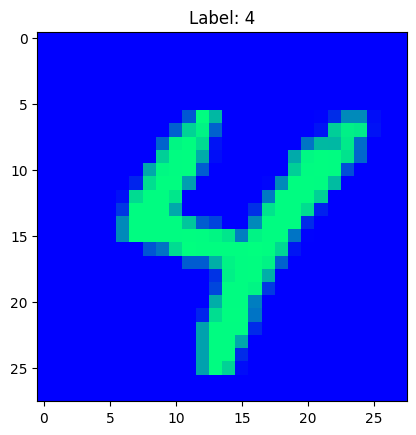

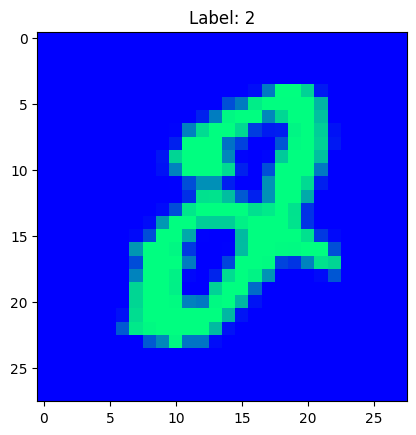

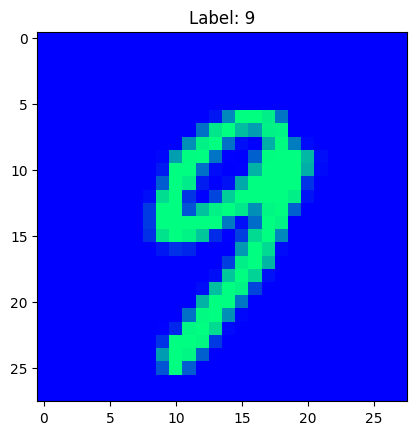

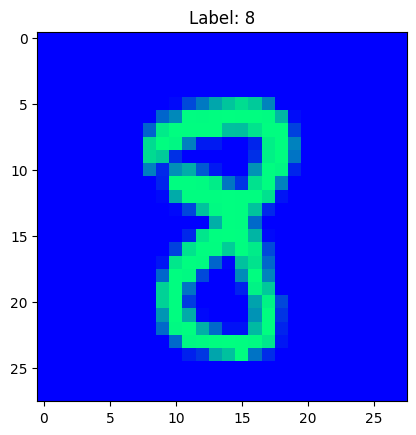

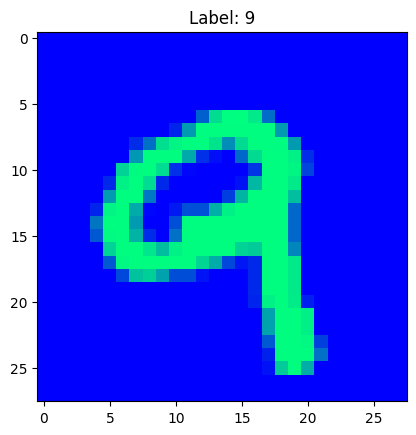

In [179]:
# b 
import random
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 100em; }</style>"))
random.seed(1)
for i in range(10):
    idx = random.randint(0,train_images.shape[0]-1)
    plt.imshow(train_images[idx], cmap="winter")
    plt.title("Label: " + str(train_labels[idx]))
    plt.show()

In [180]:
# 2
# a
train_images = train_images / 255.0
test_images = test_images / 255.0

In [181]:
# b
train_labels = np.eye(10)[train_labels]
test_labels = np.eye(10)[test_labels]

In [182]:
# 3
# a
def sigmoid(x):
    return 1/(1+np.exp(-x))

def ddx_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)



In [183]:
# b
np.random.seed(695)
input_size = 784
h1_size = 128
h2_size = 64
output_size = 10

input_weight = np.random.uniform(-1.0, 1.0, (input_size, h1_size))
input_bias = np.random.uniform(-1.0, 1.0, (1, h1_size))
h1_weight = np.random.uniform(-1.0, 1.0, (h1_size, h2_size))
h1_bias = np.random.uniform(-1.0, 1.0, (1, h2_size))
h2_weight = np.random.uniform(-1.0, 1.0, (h2_size, output_size))
h2_bias = np.random.uniform(-1.0, 1.0, (1, output_size))

In [184]:
# 4
# a

def feed_forward(x, input_weight, input_bias, activation_function="sigmoid"):
    value = np.dot(x,input_weight) + input_bias
    if activation_function == "softmax":
        activation = softmax(value)
    else:
        activation = sigmoid(value)
    return value, activation



In [185]:
# 5
# a
def categorical_crossentropy(y_true, y_pred): # used for output loss function
    n_samples = y_true.shape[0]
    y_pred_clipped = np.clip(y_pred, 1e-12, 1-1e-12)
    return -np.sum(y_true*np.log(y_pred_clipped)) / n_samples

In [186]:
# b

def gradients(x, z2, z3, a1, a2, output, w1, w2, w3, y_true, batch_size):
    #output layer
    dldw3 = np.dot(a2.T, output - y_true) / batch_size
    dldb3 = np.sum(output - y_true, axis = 0, keepdims=True) / batch_size
    # layer 2
    dldw2 = np.dot(a1.T, np.dot(output - y_true, w3.T) * ddx_sigmoid(z2)) / batch_size
    dldb2 = np.sum(np.dot(output - y_true, w3.T) * ddx_sigmoid(z2), axis = 0) / batch_size
    # layer 1
    dldw1 =  np.dot(x.T, np.dot(dldb2, w2.T) * ddx_sigmoid(z1))
    dldb1 = np.sum(np.dot(dldb2, w2.T) * ddx_sigmoid(z1), axis = 0) / batch_size
    return dldw1, dldb1, dldw2, dldb2, dldw3, dldb3


In [187]:
# 6
# a
batch_size = 128
epochs = 100
learning_rate = 0.01 # not specified on hw
losses = []
y_pred = None
for epoch in range(epochs):
    idx = np.random.permutation(train_images.shape[0])
    train_images2 = train_images[idx]
    train_labels2 = train_labels[idx]
    
    for i in range(0, train_images.shape[0] - batch_size, batch_size):
        train_images_batch = train_images2[i: i + batch_size].reshape(batch_size, -1)
        train_labels_batch = train_labels2[i: i + batch_size]
        z1, a1 = feed_forward(train_images_batch, input_weight, input_bias)
        z2, a2 = feed_forward(a1, h1_weight, h1_bias)
        z3, a3 = feed_forward(a2, h2_weight, h2_bias, activation_function="softmax")
        dldw1, dldb1, dldw2, dldb2, dldw3, dldb3 = gradients(train_images_batch, z2, z3, a1, a2, a3, input_weight, h1_weight, h2_weight, train_labels_batch, batch_size)
        input_weight -= learning_rate*dldw1 
        input_bias -= learning_rate*dldb1
        h1_weight -= learning_rate*dldw2
        h1_bias -= learning_rate*dldb2
        h2_weight -= learning_rate*dldw3
        h2_bias -= learning_rate*dldb3
    loss = categorical_crossentropy(train_labels_batch, a3)
    losses.append(loss)
    y_pred = a3
    print(f"Epoch: {epoch+1}/{epochs}, Loss: {loss}")

Epoch: 1/100, Loss: 1.790610349232281
Epoch: 2/100, Loss: 1.7727179655730247
Epoch: 3/100, Loss: 1.5131813801442395
Epoch: 4/100, Loss: 1.3428221934618985
Epoch: 5/100, Loss: 1.2870722179337584
Epoch: 6/100, Loss: 1.3128823032849568
Epoch: 7/100, Loss: 1.1071851117125502
Epoch: 8/100, Loss: 1.0794304108322412
Epoch: 9/100, Loss: 0.9849544633104582
Epoch: 10/100, Loss: 1.052738909304832
Epoch: 11/100, Loss: 0.8688647965196846
Epoch: 12/100, Loss: 0.9872150872940948
Epoch: 13/100, Loss: 0.7735120227381482
Epoch: 14/100, Loss: 0.840501008818169
Epoch: 15/100, Loss: 0.7995316428469602
Epoch: 16/100, Loss: 0.8969596856656669
Epoch: 17/100, Loss: 0.6503492991142674
Epoch: 18/100, Loss: 0.7050431443491896
Epoch: 19/100, Loss: 0.6582347942532235
Epoch: 20/100, Loss: 0.737414076839544
Epoch: 21/100, Loss: 0.7907986575761168
Epoch: 22/100, Loss: 0.580045540210665
Epoch: 23/100, Loss: 0.6133906331116168
Epoch: 24/100, Loss: 0.6189776356201173
Epoch: 25/100, Loss: 0.5630344634904318
Epoch: 26/100,

In [188]:
# 7
# a
z1, a1 = feed_forward(test_images.reshape(test_images.shape[0], -1), input_weight, input_bias)
z2, a2 = feed_forward(a1, h1_weight, h1_bias)
z3, a3 = feed_forward(a2, h2_weight, h2_bias, activation_function="softmax")
test_labels = read_idx("MNIST/t10k-labels-idx1-ubyte.gz") # get back orignal non encoded labels for comparison
accuracy = np.mean(np.argmax(a3, axis=1) == test_labels)
print(f"Test Accuracy: {accuracy*100}%")

Test Accuracy: 90.95%


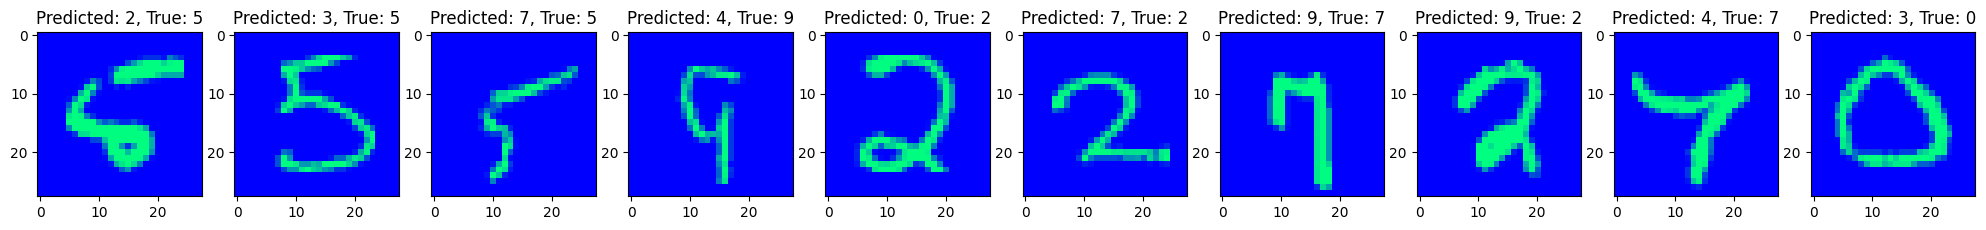

In [194]:
# 7
# b
y_pred = np.argmax(a3, axis=1)
m_idx = np.where(y_pred != test_labels)[0]
plt.figure(figsize=(25, 25))

for i, idx in enumerate(m_idx[:10]):
    plt.subplot(1, 10, i + 1)
    plt.imshow(test_images[idx], cmap='winter')
    plt.title(f"Predicted: {y_pred[idx]}, True: {test_labels[idx]}")
plt.show()